# Implementing Regularization with Linear Regression
In the previous lesson, we saw how implementing Lasso and Ridge regularization methods with linear regression 
in scikit-learn was fairly straightforward. Both Lasso() and Ridge() functions have an input parameter alpha 
that sets the strength of the regularization. The not-so-straightforward part was the question of how to choose 
the right alpha for the data and question at hand. We’re now ready to dive into this!

For starters, we’re going to run a quick Lasso implementation on the student performance dataset that we were 
working with. The dataset has 41 features relating to various factors that might influence a student’s final grade. 
Let’s take a sneak peek first:

In [1]:
import pandas as pd
df = pd.read_csv('student_math.csv')
print(df.columns, df.shape)

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'Final_Grade', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3',
       'Pstatus_T', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_health', 'Fjob_other', 'Fjob_services',
       'Fjob_teacher', 'reason_home', 'reason_other', 'reason_reputation',
       'guardian_mother', 'guardian_other', 'schoolsup_yes', 'famsup_yes',
       'paid_yes', 'activities_yes', 'nursery_yes', 'higher_yes',
       'internet_yes', 'romantic_yes'],
      dtype='object') (395, 42)


We set our predictor and outcome variables and perform a train-test-split:

In [2]:
y = df['Final_Grade']
X = df.drop(columns = ['Final_Grade'])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

We’re now ready to fit a Lasso regularized regression model by using the Lasso() function from the linear_model module:

In [3]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.05)
lasso.fit(X_train,y_train)

Lasso(alpha=0.05)

We’re going to look at the Mean Squared Error (MSE) using a function from the metrics module:

In [4]:
from sklearn.metrics import mean_squared_error
pred_train = lasso.predict(X_train)
pred_test = lasso.predict(X_test)
training_mse = mean_squared_error(y_train, pred_train)
test_mse = mean_squared_error(y_test, pred_test)
print('Training Error:',  training_mse)
print('Test Error:', test_mse)

Training Error: 2.8132075838851414
Test Error: 4.474769444129442


We see that the test error is more than 1.5 times that of the training error. This is an indicator that the model is still overfitting the data and that there is room to regularize more.

# Tuning the Regularization Hyperparameter
We chose alpha to be 0.05 (the scikit-learn default is 1.0). It is worth recalling here that an alpha of zero is equivalent to no regularization. And when alpha is allowed to get too big we have the opposite problem of biasing our model and consequently underfitting the data.

One way to figure out the “Goldilocks zone” in this bias-variance tradeoff is to try multiple values of alpha. Iterating over an array of alpha values and plotting the resulting training and test errors against the corresponding alpha‘s gets us the following figure:
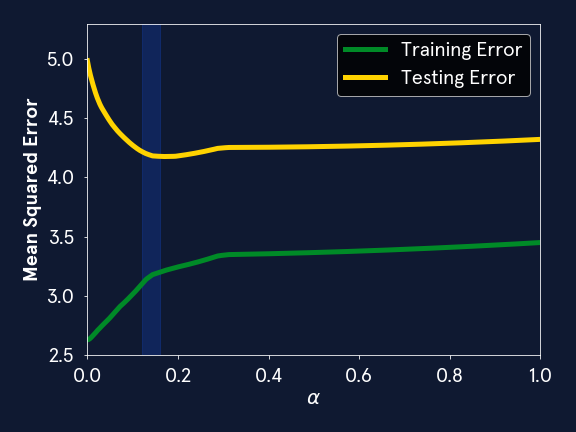

We see that the test error goes down as we increase alpha until a certain value after which it begins to go up and then seems to slowly but steadily increase. Our optimal alpha thus lies somewhere in the blue band shown, likely a number between 0.12 and 0.16.

There is, however, another question to consider: would this be the same for a different train-test split? It is quite possible that our tuned hyperparameter might be different if we did a different train-test split. Luckily, scikit-learn has just the feature for us. GridSearchCV, short for “Grid Search Cross-validation” helps us to satisfactorily resolve this while automating and speeding up our hyperparameter search - all within a couple of lines of code!

# Automate the Hyperparameter Search with GridsearchCV
GridSearchCV uses a “k-fold” cross-validation method to search for the optimal hyperparameter in a machine learning algorithm. The k-fold method iteratively splits the dataset into train-test splits “k” times such that every point in the sample gets to be within the test data at least once. For instance, if we wanted to do 5-fold cross-validation, our data would be split into a 80:20 train-test split five times. To visualize this, imagine that our data is contained within this green box as shown below:

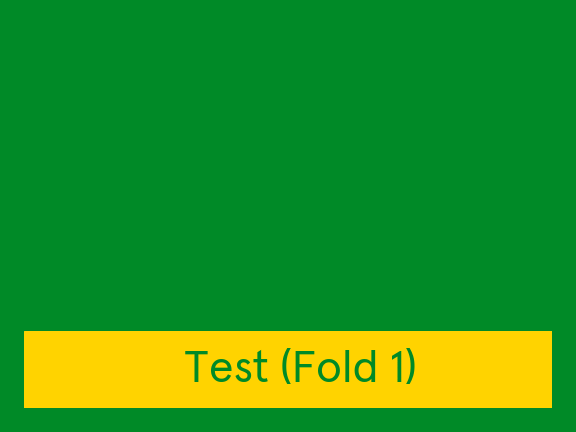

Our five “folds” can be represented by the yellow box. Each location of the box shows a specific train-test split. If we iterated our model fit over these five folds, every part of the data gets to be “test data” once. Doing a k-fold cross-validation makes sure that the conclusions we’re drawing about our data are not the result of a sampling effect but are truly representative of all of the data.

GridSearchCV takes in the following arguments:

* estimator: the machine learning algorithm whose hyperparameters we’re tuning (in our case, Lasso() or Ridge())
* param_grid: a grid of potential values for the hyperparameters that are being tuned. This has to be in the form of a dictionary with the keys representing the parameter inputs to the model and the values, lists of potential parameter values. For instance in the case of our Lasso implementation, we have only one hyperparameter we’re tuning, i.e., alpha.

Since we don’t have an idea of what order of magnitude alpha needs to be (i.e., is it between 0.01-0.1 or 0.1-1.0 or 1-10 and so on), using NumPy‘s logspace function can be very useful. It is similar to linspace except that it gets us numbers that are evenly spaced in the logarithmic scale. (It takes in the powers of ten that we’re searching between, so if we wanted to search between 0.01 to 100, we’d set its inputs to -2 and 2 respectively.)

In [5]:
import numpy as np
## an array of alpha values between 0.000001 and 1.0
alpha_array = np.logspace(-6, 0, 100)
 
#dict with key (alpha) and values being alpha_array
tuned_parameters = [{'alpha': alpha_array}]

* scoring: the metric used to evaluate the performance of the model on the test set. GridSearchCV searches for the set of parameters within param_grid that maximizes this value.
scikit-learn‘s documentation has an exhaustive list of scoring strategies. The argument for mean squared error, our chosen metric, is neg_mean_squared_error. It’s a negative value because GridSearchCV maximizes the score it’s given.

* cv: specifies the way the cross-validation is performed. The default here is the 5-fold cross-validation method that’s described above. Otherwise one can set a different number of folds (i.e., an alternate positive integer value for k)

* return_train_score: a Boolean argument specifying whether we would like the output of our fit to return the scores on training data every folds The default here is False but we’re going to set it to True as we’re using GridSearchCV to correct for overfitting and would like to be kept in the loop about the training score.

Consider our implementation of Lasso on the student performance dataset. Suppose we wanted to check the result of implementing different values of alpha and wanted to do multiple train-test splits to make sure we’re covering the entire sample. We could do this in one line as follows:

In [6]:
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(estimator = Lasso(), param_grid = tuned_parameters, scoring = 'neg_mean_squared_error', cv = 5, return_train_score = True)
model.fit(X, y)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid=[{'alpha': array([1.00000000e-06, 1.14975700e-06, 1.32194115e-06, 1.51991108e-06,
       1.74752840e-06, 2.00923300e-06, 2.31012970e-06, 2.65608778e-06,
       3.05385551e-06, 3.51119173e-06, 4.03701726e-06, 4.64158883e-06,
       5.33669923e-06, 6.13590727e-06, 7.05480231e-06, 8.11130831e-06,
       9.32603347e-06, 1.07226722e-05, 1.23284674e-05, 1...
       7.05480231e-02, 8.11130831e-02, 9.32603347e-02, 1.07226722e-01,
       1.23284674e-01, 1.41747416e-01, 1.62975083e-01, 1.87381742e-01,
       2.15443469e-01, 2.47707636e-01, 2.84803587e-01, 3.27454916e-01,
       3.76493581e-01, 4.32876128e-01, 4.97702356e-01, 5.72236766e-01,
       6.57933225e-01, 7.56463328e-01, 8.69749003e-01, 1.00000000e+00])}],
             return_train_score=True, scoring='neg_mean_squared_error')

The result of the fit object has many attributes, of which we’re going to examine the ones that are most important to us:

* The cv_results_ object gives us the details of every model fit corresponding to a particular alpha value and the train-test split of each fold. (Our alpha array had 100 values and we did a 5-fold cross-validated search - so this is essentially equivalent to performing 500 model fits!) We’re specifically going to look at the mean train and test scores across the 5 train-test splits:

In [7]:
test_scores = model.cv_results_['mean_test_score']
train_scores = model.cv_results_['mean_train_score']

Each of the above objects is an array the size of our param_grid, i.e., the number of alpha values we’ve specified.

* Additionally, the model fit object also gives us: best_estimator_, best_score_ and best_params_. To get the alpha that is optimal to our scoring strategy, we can do the following:

In [8]:
print(model.best_params_, model.best_score_)

{'alpha': 0.12328467394420659} -3.743294901559115


(Note that the score is the negative of least test mean squared error!) If we were to replicate the previous plot, i.e., plot our new training and test scores as a function of alpha and over plot the line corresponding to the “best” alpha value, we get the following:

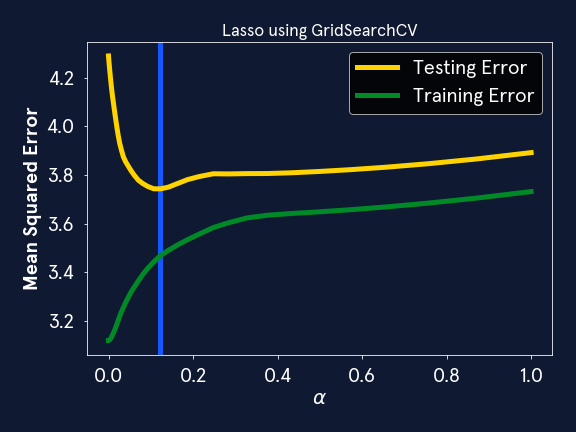

The blue line here is our tuned hyperparameter and this value of alpha (~0.1233) corresponds to the optimal cross-validated test and training error values.

# Implementing Regularization with a Logistic Regression Classifier
So far we’ve seen different implementations of regularization with linear regression. What if we were working with a classification problem instead? We’re going to discuss a couple of ways of implementing L1 and L2 regularization with a logistic regression classifier.

## On alpha‘s, C‘s and solver‘s: some scikit-learn pointers!
This might come as a surprise to you (it certainly did to me): the default scikit-learn logistic regression implementation is already regularized! It is L2-regularized with an alpha of 100. To elaborate, let’s take a look at a couple of attributes that go into the logistic regression model:

* penalty: The options here are ‘l1’, ‘l2’, ‘none’ and ‘elasticnet’ and the default is ‘l2’.

* C: The inverse of regularization strength - the default value is 1.0.

* solver: The options are {‘lbfgs’, ‘liblinear’, ‘newton_cg’, ‘sag’, ‘saga’}.

The LogisticRegression() function differs from Lasso() and Ridge() functions for Linear Regression in that its input is the parameter C, which is the inverse of alpha. This is important to keep in mind, especially while setting up the parameter grid prior to implementing GridSearchCV.

Let’s take a look at our different options for implementation then:

* No regularization:

In [9]:
from sklearn.linear_model import LogisticRegression
logistic_no_regularization = LogisticRegression(penalty = 'none')

* Lasso (L1): The L1 implementation requires setting the penalty attribute to ‘l1’ and also setting the solver attribute to ‘liblinear’

In [10]:
tuning_C = {'C': np.logspace(-3,2, 100)}
logistic_lasso = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = tuning_C )

It is worth noting here that there is a solver attribute in scikit-learn for most machine learning algorithms. The default solver for LogisticRegression() is lbfgs, however the only solver that can be used with Lasso Regularization is the ‘liblinear’ solver and hence it needs to be explicitly specified. (We’re not going to go into further details at the moment but the docs are always a great place to get some more pointers!)

* Ridge (L2): Remember the default is ‘l2’! So all we need to do is specify C here:

In [11]:
logistic_ridge = LogisticRegression(C = tuning_C )

* Elasticnet: The penalty options ‘l1’, ‘l2’ and ‘none’ are self-evident but we haven’t covered ‘elasticnet’ in this course. Elasticnet Regularization is a combination of L1 and L2 regularization and has two penalty terms, one for L1 and one for L2!

In [ ]:
logistic_elasticnet = LogisticRegression(penalty = 'elasticnet', solver = 'saga', C = tuning_C, l1_ratio = ___ )

* To implement Elasticnet one needs two hyperparameters: C, which specifies the regularization strength and an additional mixing hyperparameter, ‘l1_ratio’ which specifies how much L1 regularization used relative to L2.
* ‘l1_ratio’ takes values between 0 and 1, with 1 being the same as applying just L1 and 0, being equivalent to applying just L2 penalties respectively.
* The solver ‘saga’ needs to be explicitly specified here.

# Tuning hyperparameter C using GridSearchCV and LogisticRegressionCV
Implementing Lasso or Ridge with logistic regression in scikit-learn is as simple as picking the right arguments for penalty and C. We’ve written some sample code here to find the optimal C using GridSearchCV: (Remember that C is the inverse of alpha so greater the C, the lesser the amount of regularization!)

In [ ]:
#Making an array of C's; here we're choosing 100 values between 0.001 and 100
C_array  = np.logspace(-3,2, 100)
 
#Making a dict to enter as an input to param_grid
tuning_C = {'C':C_array}
clf = LogisticRegression(penalty = 'l1', solver =  'liblinear')
gs = GridSearchCV(clf, param_grid = tuning_C, scoring = 'accuracy', cv = 5)

Since Logistic Regression is such a commonly used algorithm, scikit-learn has a function that makes the above faster and neater, the LogisticRegressionCV() function. If we were to implement the code challenge using this function, it would look as follows:

In [13]:
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV( Cs=np.logspace(-3,2, 100),
                                  penalty='l2',
                                  scoring='accuracy', cv=5,
                                  random_state=42,max_iter=10000)
model.fit(X, y)
print(model.C_, model.scores_[1].mean(axis=0).max())
 

C:\Users\jbradford\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\jbradford\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jbradford\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0

ValueError: could not broadcast input array from shape (100,18,42) into shape (100,)

Which is the same output as we get from the code challenge! Note that there are slight syntactical differences between the outputs of GridsearchCV and LogisticRegressionCV. In general, many algorithms in scikit-learn have their own special grid search cross-validation function such as LassoCV(), RidgeCV(), ElasticnetCV(), etc.

# Conclusion
We have covered multiple ways of implementing regularization with linear and logistic regression in scikit-learn in this article. There are a few essential (albeit annoying) differences between these methods. Together they offer a powerful toolkit to find the optimal regularization for regression and classification methods. You can try out all these techniques in the upcoming project!